In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.1 MB/s eta 0:00:00


In [ ]:
import pickle
import numpy as np
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [41]:
X_test = pd.read_csv('X_test_final.csv')
y_test = pd.read_csv('y_test_final.csv')

In [42]:
model1 = CatBoostClassifier().load_model('catboost.pkl')

In [48]:
model2 = joblib.load('random_forest_classifier.pkl')

In [44]:
y_pred1 = model1.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred1))

print("\nClassification Report:")
print(classification_report(y_test, y_pred1, digits=4))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred1))

Confusion Matrix:
[[89123 11284]
 [ 3035 97514]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9671    0.8876    0.9256    100407
           1     0.8963    0.9698    0.9316    100549

    accuracy                         0.9287    200956
   macro avg     0.9317    0.9287    0.9286    200956
weighted avg     0.9317    0.9287    0.9286    200956


Accuracy Score:
0.9287455960508768


In [49]:
y_pred2 = model2.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred2))

print("\nClassification Report:")
print(classification_report(y_test, y_pred2, digits=4))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred2))

Confusion Matrix:
[[87893 12514]
 [ 1819 98730]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9797    0.8754    0.9246    100407
           1     0.8875    0.9819    0.9323    100549

    accuracy                         0.9287    200956
   macro avg     0.9336    0.9286    0.9285    200956
weighted avg     0.9336    0.9287    0.9285    200956


Accuracy Score:
0.9286759290590975


In [50]:
accuracy1 = 0.9287455960508768
accuracy2 = 0.9286759290590975
total = accuracy1 + accuracy2
weight1 = accuracy1 / total
weight2 = accuracy2 / total

In [51]:
class WeightedEnsemble:
    def __init__(self, model1, model2, weight1, weight2):
        self.model1 = model1
        self.model2 = model2
        self.weight1 = weight1
        self.weight2 = weight2

    def predict_proba(self, X):
        proba1 = self.model1.predict_proba(X)[:, 1]
        proba2 = self.model2.predict_proba(X)[:, 1]
        ensemble_proba = self.weight1 * proba1 + self.weight2 * proba2
        return np.vstack((1 - ensemble_proba, ensemble_proba)).T

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= 0.5).astype(int)


In [52]:
ensemble_model = WeightedEnsemble(model1, model2, weight1, weight2)

ensemble_pred = ensemble_model.predict(X_test)
print("Ensemble Classification Report:\n", classification_report(y_test, ensemble_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, ensemble_pred))
print("Accuracy:", accuracy_score(y_test, ensemble_pred))

Ensemble Classification Report:
               precision    recall  f1-score   support

           0     0.9828    0.8911    0.9347    100407
           1     0.9005    0.9844    0.9406    100549

    accuracy                         0.9378    200956
   macro avg     0.9417    0.9378    0.9377    200956
weighted avg     0.9416    0.9378    0.9377    200956

Confusion Matrix:
 [[89475 10932]
 [ 1567 98982]]
Accuracy: 0.9378023049821852


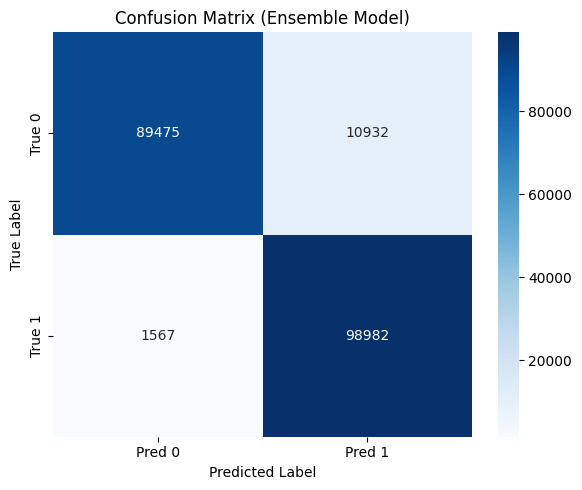

In [54]:
cm = confusion_matrix(y_test, ensemble_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['True 0', 'True 1'])
plt.title("Confusion Matrix (Ensemble Model)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

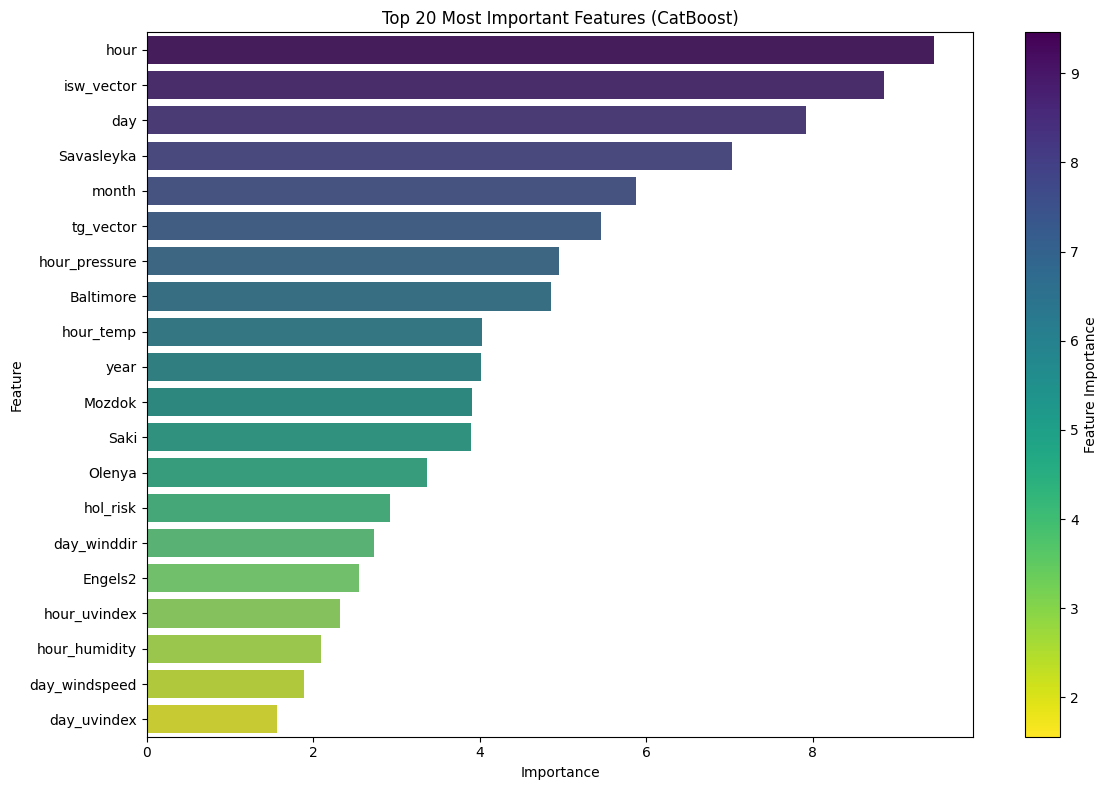

In [55]:
feature_cols = X_test.columns.tolist()

importances1 = model1.get_feature_importance()
features1 = pd.DataFrame({"Feature": feature_cols, "Importance": importances1})
top20_1 = features1.sort_values(by="Importance", ascending=False).head(20)

plt.figure(figsize=(12, 8))
norm = plt.Normalize(top20_1['Importance'].min(), top20_1['Importance'].max())
sm = plt.cm.ScalarMappable(cmap="viridis_r", norm=norm)
sm.set_array([])

ax = sns.barplot(
    x="Importance",
    y="Feature",
    data=top20_1,
    hue="Feature",
    palette=sns.color_palette("viridis", n_colors=len(top20_1)),
    dodge=False,
    legend=False
)
plt.colorbar(sm, ax=ax).set_label('Feature Importance')
plt.title("Top 20 Most Important Features (CatBoost)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

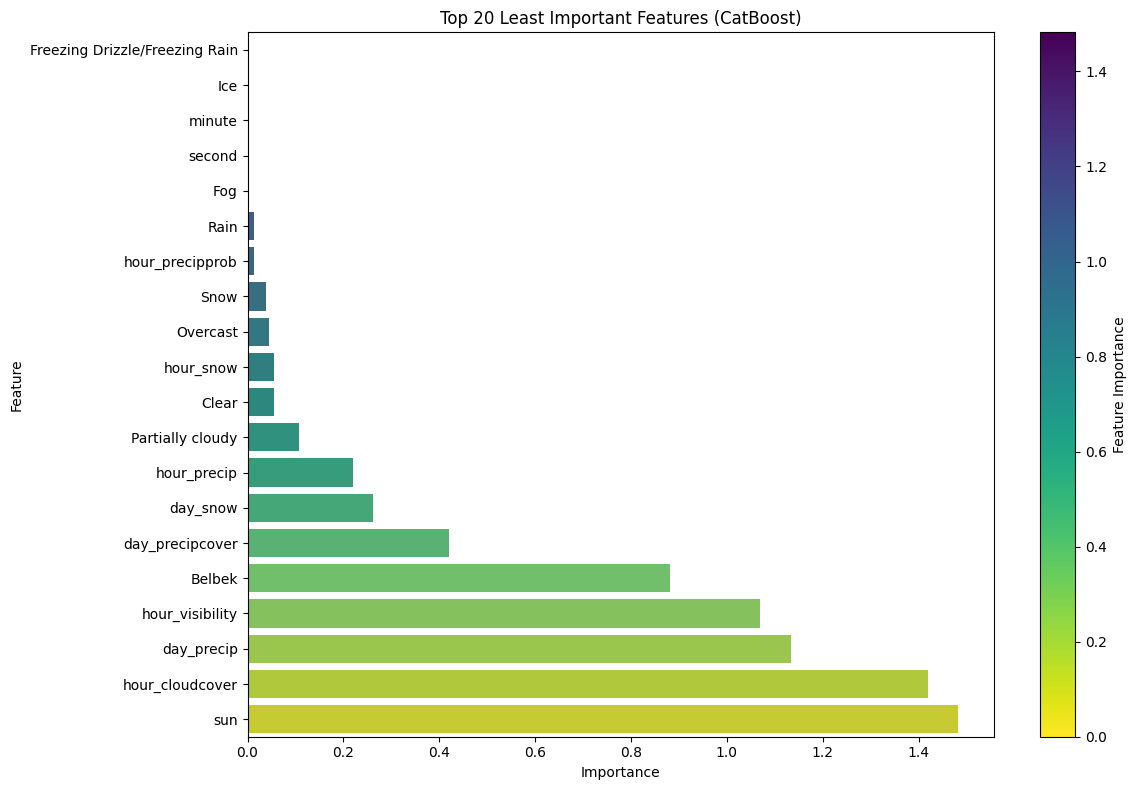

In [56]:
bottom20_1 = features1.sort_values(by="Importance", ascending=True).head(20)

plt.figure(figsize=(12, 8))
norm = plt.Normalize(bottom20_1['Importance'].min(), bottom20_1['Importance'].max())
sm = plt.cm.ScalarMappable(cmap="viridis_r", norm=norm)
sm.set_array([])

ax = sns.barplot(
    x="Importance",
    y="Feature",
    data=bottom20_1,
    hue="Feature",
    palette=sns.color_palette("viridis", n_colors=len(bottom20_1)),
    dodge=False,
    legend=False
)
plt.colorbar(sm, ax=ax).set_label('Feature Importance')
plt.title("Top 20 Least Important Features (CatBoost)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


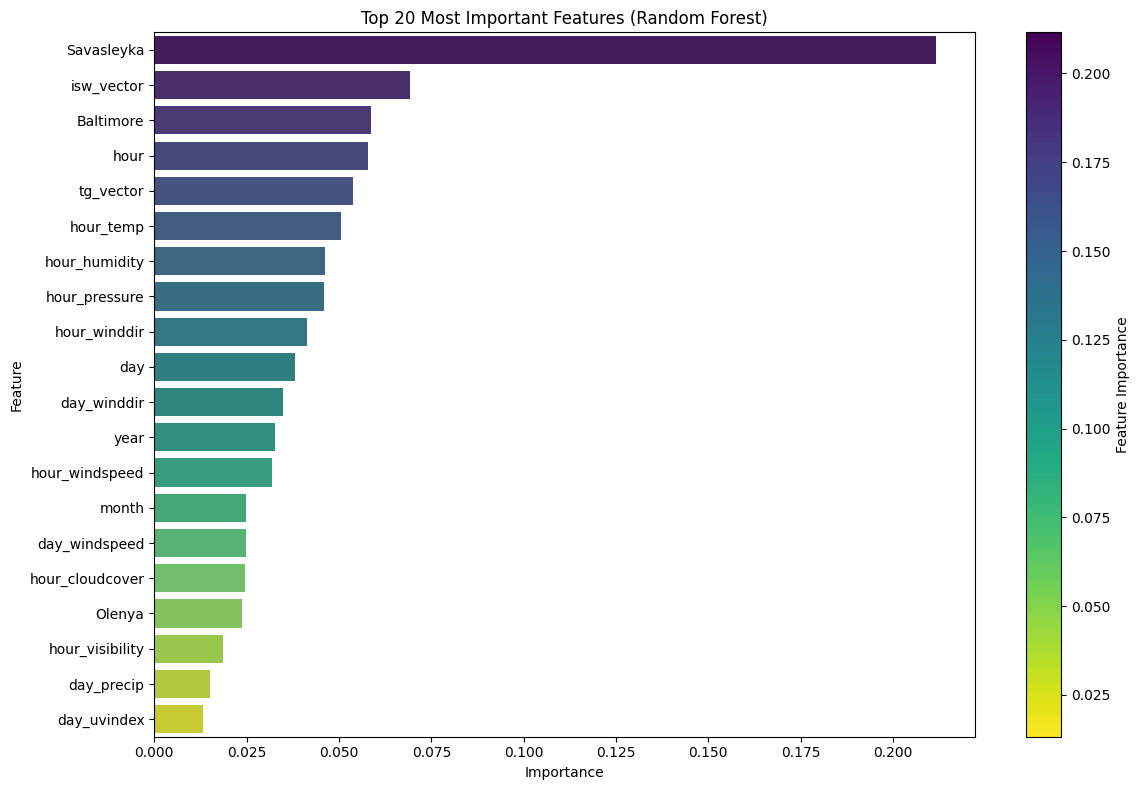

In [57]:
importances2 = model2.feature_importances_
features2 = pd.DataFrame({"Feature": feature_cols, "Importance": importances2})
top20_2 = features2.sort_values(by="Importance", ascending=False).head(20)

plt.figure(figsize=(12, 8))
norm = plt.Normalize(top20_2['Importance'].min(), top20_2['Importance'].max())
sm = plt.cm.ScalarMappable(cmap="viridis_r", norm=norm)
sm.set_array([])

ax = sns.barplot(
    x="Importance",
    y="Feature",
    data=top20_2,
    hue="Feature",
    palette=sns.color_palette("viridis", n_colors=len(top20_2)),
    dodge=False,
    legend=False
)
plt.colorbar(sm, ax=ax).set_label('Feature Importance')
plt.title("Top 20 Most Important Features (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

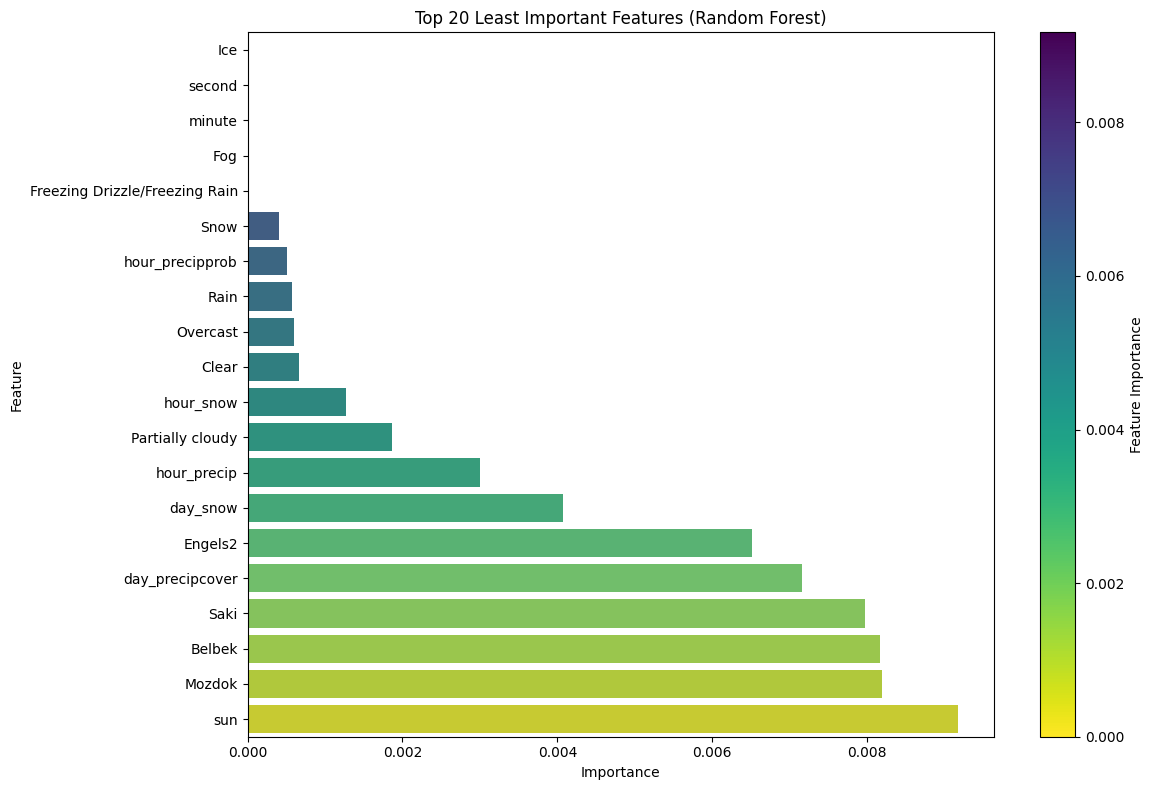

In [58]:
bottom20_2 = features2.sort_values(by="Importance", ascending=True).head(20)

plt.figure(figsize=(12, 8))
norm = plt.Normalize(bottom20_2['Importance'].min(), bottom20_2['Importance'].max())
sm = plt.cm.ScalarMappable(cmap="viridis_r", norm=norm)
sm.set_array([])

ax = sns.barplot(
    x="Importance",
    y="Feature",
    data=bottom20_2,
    hue="Feature",
    palette=sns.color_palette("viridis", n_colors=len(bottom20_2)),
    dodge=False,
    legend=False
)
plt.colorbar(sm, ax=ax).set_label('Feature Importance')
plt.title("Top 20 Least Important Features (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [59]:
joblib.dump(ensemble_model, 'ensemble_model.pkl')


['ensemble_model.pkl']